Welcome to Weedle's cave. Will you be able to predict the outcome of future matches?

To do it you will have the pokemon characteristics and the results of previous combats.

Three files are available. The first one contains the Pokemon characteristics (the first column being the id of the Pokemon). The second one contains information about previous combats. The first two columns contain the ids of the combatants and the third one the id of the winner. Important: The Pokemon in the first columns attacks first.

The goal is to develop a Machine Learning model able to predict the result of future pokemon combats.

# Importing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import re
import warnings
warnings.filterwarnings('ignore') # To supress warnings



# Loading datasets and first glance

In [2]:
pokemonDf = pd.read_csv("pokemon.csv")

print(pokemonDf.info())
pokemonDf

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   #           800 non-null    int64 
 1   Name        799 non-null    object
 2   Type 1      800 non-null    object
 3   Type 2      414 non-null    object
 4   HP          800 non-null    int64 
 5   Attack      800 non-null    int64 
 6   Defense     800 non-null    int64 
 7   Sp. Atk     800 non-null    int64 
 8   Sp. Def     800 non-null    int64 
 9   Speed       800 non-null    int64 
 10  Generation  800 non-null    int64 
 11  Legendary   800 non-null    bool  
dtypes: bool(1), int64(8), object(3)
memory usage: 69.7+ KB
None


,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,80,82,83,100,100,80,1,False
3,4,Mega Venusaur,Grass,Poison,80,100,123,122,120,80,1,False
4,5,Charmander,Fire,NaN,39,52,43,60,50,65,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...
795,796,Diancie,Rock,Fairy,50,100,150,100,150,50,6,True
796,797,Mega Diancie,Rock,Fairy,50,160,110,160,110,110,6,True
797,798,Hoopa Confined,Psychic,Ghost,80,110,60,150,130,70,6,True
798,799,Hoopa Unbound,Psychic,Dark,80,160,60,170,130,80,6,True


<u>Observations :</u>

* We're given for each of the 800 pokemons :
    * their types (second type can be null)
    * their stats
    * their generation (i.e. which generation of games where they first appeared)
    * if they are a legendary or not
* One pokemon has their name missing
* Some of the pokemon are alternative forms of the same pokemon. However these forms have different types and/or stats.

In [3]:
combatsDf = pd.read_csv("combats.csv")

print(combatsDf.info())
combatsDf

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   First_pokemon   50000 non-null  int64
 1   Second_pokemon  50000 non-null  int64
 2   Winner          50000 non-null  int64
dtypes: int64(3)
memory usage: 1.1 MB
None


,First_pokemon,Second_pokemon,Winner
0,266,298,298
1,702,701,701
2,191,668,668
3,237,683,683
4,151,231,151
...,...,...,...
49995,707,126,707
49996,589,664,589
49997,303,368,368
49998,109,89,109


<u>Observations :</u>

* First_pokemon will attack first in combat. We will see if it has anything to do with the difference in Speed stat between the two pokemons
* Pokemons are identified with their ids (#)
* 50 000 combats has been performed

In [4]:
testsDf = pd.read_csv("tests.csv")

print(testsDf.info())
testsDf

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   First_pokemon   10000 non-null  int64
 1   Second_pokemon  10000 non-null  int64
dtypes: int64(2)
memory usage: 156.4 KB
None


,First_pokemon,Second_pokemon
0,129,117
1,660,211
2,706,115
3,195,618
4,27,656
...,...,...
9995,216,498
9996,113,404
9997,493,104
9998,643,259


<u>Observation :</u>

Same format as the combats dataset without the winner of course.

In [5]:
statsColumns = [
    'HP', 
    'Attack', 
    'Defense', 
    'Sp. Atk',
    'Sp. Def', 
    'Speed'
]

typesColumns = [
    'Type 1',
    'Type 2'
]

# Cleaning dataset

We first rename the id column in the pokemon dataframe.

In [6]:
pokemonDf.rename(columns= {'#' : "id"}, inplace= True)
pokemonDf.set_index("id", drop= True, inplace= True)

We look for the pokemon whose name is missing.

In [7]:
missingPokemon = pokemonDf.loc[pokemonDf.Name.isna()]
missingPokemon

,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
id,,,,,,,,,,,
63,NaN,Fighting,NaN,65,105,60,60,70,95,1,False


We'll identify him by checking which pokemons come before and after.

In [8]:
pokemonDf.loc[62:64]

,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
id,,,,,,,,,,,
62,Mankey,Fighting,NaN,40,80,35,35,45,70,1,False
63,NaN,Fighting,NaN,65,105,60,60,70,95,1,False
64,Growlithe,Fire,NaN,55,70,45,70,50,60,1,False


Who's that pokemon ? It's Primeape !

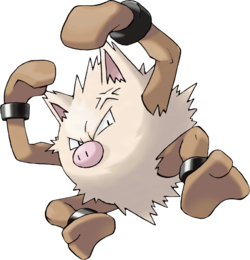

In [9]:
pokemonDf.at[63,"Name"] = "Primeape"

Each pokemon has at least one type. For pokemons who have a single type We'll just replace the missing values in 'Type 2' by 'None'.

In [10]:
pokemonDf['Type 2'] = pokemonDf['Type 2'].fillna('None')

We are now done dealing with missing values.

# Feature Engineering

## On the pokemons characteristics DataFrame

We'll add a variable that is the sum of all stats to get an overall evaluation of one pokemon.

In [11]:
pokemonDf['TotalStats'] = pokemonDf[statsColumns].sum(axis = 1)
pokemonDf

,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,TotalStats
id,,,,,,,,,,,,
1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,1,False,318
2,Ivysaur,Grass,Poison,60,62,63,80,80,60,1,False,405
3,Venusaur,Grass,Poison,80,82,83,100,100,80,1,False,525
4,Mega Venusaur,Grass,Poison,80,100,123,122,120,80,1,False,625
5,Charmander,Fire,None,39,52,43,60,50,65,1,False,309
...,...,...,...,...,...,...,...,...,...,...,...,...
796,Diancie,Rock,Fairy,50,100,150,100,150,50,6,True,600
797,Mega Diancie,Rock,Fairy,50,160,110,160,110,110,6,True,700
798,Hoopa Confined,Psychic,Ghost,80,110,60,150,130,70,6,True,600


## On the pokemons combats DataFrame

We first we add a "Loser" column. It's not a new feature but it may be handy when we'll perform EDA.

In [12]:
combatsDf["Loser"] = combatsDf.First_pokemon * (combatsDf.First_pokemon != combatsDf.Winner) + combatsDf.Second_pokemon * (combatsDf.Second_pokemon != combatsDf.Winner)

In Pokemon games types are used to calculate a damage multiplier. For example hitting a pure Fire type pokemon with a water type move will set the damage multiplier to 2. If we assume that this mechanic is present here and that our pokemons only attack with moves of their own types, we can calculate the best damage multiplier we can get.

In [13]:
pokemonTypes = ["Normal", "Fire", "Water", "Electric", "Grass", "Ice", "Fighting", "Poison", "Ground", "Flying", "Psychic", "Bug", "Rock", "Ghost", "Dragon", "Dark", "Steel", "Fairy"]
    
multipliersArray = np.array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1/2, 0, 1, 1, 1/2, 1],
                    [1, 1/2, 1/2, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1/2, 1, 1/2, 1, 2, 1],
                    [1, 2, 1/2, 1, 1/2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1/2, 1, 1, 1],
                    [1, 1, 2, 1/2, 1/2, 1, 1, 1, 0, 2, 1, 1, 1, 1, 1/2, 1, 1, 1],
                    [1, 1/2, 2, 1, 1/2, 1, 1, 1/2, 2, 1/2, 1, 1/2, 2, 1, 1/2, 1, 1/2, 1],
                    [1, 1/2, 1/2, 1, 2, 1/2, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1/2, 1],
                    [2, 1, 1, 1, 1, 2, 1, 1/2, 1, 1/2, 1/2, 1/2, 2, 0, 1, 2, 2, 1/2],
                    [1, 1, 1, 1, 2, 1, 1, 1/2, 1/2, 1, 1, 1, 1/2, 1/2, 1, 1, 0, 2],
                    [1, 2, 1, 2, 1/2, 1, 1, 2, 1, 0, 1, 1/2, 2, 1, 1, 1, 2, 1],
                    [1, 1, 1, 1/2, 2, 1, 2, 1, 1, 1, 1, 2, 1/2, 1, 1, 1, 1/2, 1],
                    [1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1/2, 1, 1, 1, 1, 0, 1/2, 1],
                    [1, 1/2, 1, 1, 2, 1, 1/2, 1/2, 1, 1/2, 2, 1, 1, 1/2, 1, 2, 1/2, 1/2],
                    [1, 2, 1, 1, 1, 2, 1/2, 1, 1/2, 2, 1, 2, 1, 1, 1, 1, 1/2, 1],
                    [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1/2, 1, 1],
                    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1/2, 0],
                    [1, 1, 1, 1, 1, 1, 1/2, 1, 1, 1, 2, 1, 1, 2, 1, 1/2, 1, 1/2],
                    [1, 1/2, 1/2, 1/2, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1/2, 2],
                    [1, 1/2, 1, 1, 1, 1, 2, 1/2, 1, 1, 1, 1, 1, 1, 2, 2, 1/2, 1]])

typeEffectivenessDf = pd.DataFrame(data= multipliersArray, columns= pokemonTypes, index= pokemonTypes)

def getBestDamageMultiplier(attackingPokemon : int, defendingPokemon : int):
    attackingPokemonType1 = pokemonDf.loc[attackingPokemon, "Type 1"]
    attackingPokemonType2 = pokemonDf.loc[attackingPokemon, "Type 2"]
    defendingPokemonType1 = pokemonDf.loc[defendingPokemon, "Type 1"]
    defendingPokemonType2 = pokemonDf.loc[defendingPokemon, "Type 2"]
    
    if attackingPokemonType2 != 'None':   
        if defendingPokemonType2 != 'None':
            effectivenessType1 = typeEffectivenessDf.loc[attackingPokemonType1,defendingPokemonType1] * typeEffectivenessDf.loc[attackingPokemonType1,defendingPokemonType2]
            effectivenessType2 = typeEffectivenessDf.loc[attackingPokemonType2,defendingPokemonType1] * typeEffectivenessDf.loc[attackingPokemonType2,defendingPokemonType2]
        else:
            effectivenessType1 = typeEffectivenessDf.loc[attackingPokemonType1,defendingPokemonType1]
            effectivenessType2 = typeEffectivenessDf.loc[attackingPokemonType2,defendingPokemonType1]
            
        return max(effectivenessType1, effectivenessType2)
    else:
        if defendingPokemonType2 != 'None':
            effectivenessType1 = typeEffectivenessDf.loc[attackingPokemonType1,defendingPokemonType1] * typeEffectivenessDf.loc[attackingPokemonType1,defendingPokemonType2]
        else:
            effectivenessType1 = typeEffectivenessDf.loc[attackingPokemonType1,defendingPokemonType1]
        
        return effectivenessType1
    


In [14]:
combatsDf["First_pokemon_bestDamageMultiplier"] = combatsDf.apply(lambda x : getBestDamageMultiplier(x.First_pokemon, x.Second_pokemon), axis=1)
combatsDf["Second_pokemon_bestDamageMultiplier"]  = combatsDf.apply(lambda x : getBestDamageMultiplier(x.Second_pokemon, x.First_pokemon), axis=1)    
combatsDf

,First_pokemon,Second_pokemon,Winner,Loser,First_pokemon_bestDamageMultiplier,Second_pokemon_bestDamageMultiplier
0,266,298,298,266,1.0,4.0
1,702,701,701,702,2.0,1.0
2,191,668,668,191,1.0,1.0
3,237,683,683,237,0.5,1.0
4,151,231,151,231,2.0,1.0
...,...,...,...,...,...,...
49995,707,126,707,126,1.0,1.0
49996,589,664,589,664,2.0,0.0
49997,303,368,368,303,1.0,1.0
49998,109,89,109,89,0.5,0.5


A pokemon combat is lose when one of the pokemons HP fall to 0. These HP are reduced by the amount of damages are done by an opposite pokemon.

Given how this amount of damages is calculated in the main games (see : https://bulbapedia.bulbagarden.net/wiki/Damage#Damage_calculation), it could be interesting to inroduce the following ratios :

\begin{align*}
   phAtkRatio  &= \frac{Attack_a}{Defense_d} \\
   spAtkRatio  &= \frac{Sp. Atk_a}{Sp. Def_d} \\
   maxAtkRatio &= \max(phAtkRatio, spAtkRatio) \\
\end{align*}

Where $a$ and $d$ respectivly indicates that attacking and defending pokemon.

Also in the main games the pokemon with the highest Speed attacks first (in general, there are some exceptions). So we will also introduce :

$$ hasMoreSpeed =
\begin{cases}
 1 \text{ if } Speed_f > Speed_s\\
 0 \text{ otherwise }
\end{cases}
$$

Where $f$ is the first pokemon and $s$ the second pokemon (as written in combats.csv)

In [15]:
combatsDf["First_pokemon_phAtkRatio"] = pokemonDf.loc[combatsDf.First_pokemon]["Attack"].values / pokemonDf.loc[combatsDf.Second_pokemon]["Defense"].values
combatsDf["Second_pokemon_phAtkRatio"]  = pokemonDf.loc[combatsDf.Second_pokemon]["Attack"].values / pokemonDf.loc[combatsDf.First_pokemon]["Defense"].values    

combatsDf["First_pokemon_spAtkRatio"] = pokemonDf.loc[combatsDf.First_pokemon]["Sp. Atk"].values / pokemonDf.loc[combatsDf.Second_pokemon]["Sp. Def"].values
combatsDf["Second_pokemon_spAtkRatio"]  = pokemonDf.loc[combatsDf.Second_pokemon]["Sp. Atk"].values / pokemonDf.loc[combatsDf.First_pokemon]["Sp. Def"].values 

combatsDf["First_pokemon_maxAtkRatio"] = combatsDf.apply(lambda x: max(x.First_pokemon_phAtkRatio, x.First_pokemon_spAtkRatio), axis=1)
combatsDf["Second_pokemon_maxAtkRatio"]  = combatsDf.apply(lambda x: max(x.Second_pokemon_phAtkRatio, x.Second_pokemon_spAtkRatio), axis=1)


combatsDf["First_pokemon_hasMoreSpeed"] = (pokemonDf.loc[combatsDf.First_pokemon]["Speed"].values - pokemonDf.loc[combatsDf.Second_pokemon]["Speed"].values) > 0

combatsDf

,First_pokemon,Second_pokemon,Winner,Loser,First_pokemon_bestDamageMultiplier,Second_pokemon_bestDamageMultiplier,First_pokemon_phAtkRatio,Second_pokemon_phAtkRatio,First_pokemon_spAtkRatio,Second_pokemon_spAtkRatio,First_pokemon_maxAtkRatio,Second_pokemon_maxAtkRatio,First_pokemon_hasMoreSpeed
0,266,298,298,266,1.0,4.0,1.600000,1.400000,1.125000,1.200000,1.600000,1.400000,False
1,702,701,701,702,2.0,1.0,1.000000,1.791667,1.000000,0.558140,1.000000,1.791667,False
2,191,668,668,191,1.0,1.0,0.533333,0.882353,0.842105,1.190476,0.842105,1.190476,False
3,237,683,683,237,0.5,1.0,0.444444,3.000000,0.777778,1.500000,0.777778,3.000000,False
4,151,231,151,231,2.0,1.0,0.260870,0.080000,0.500000,0.142857,0.500000,0.142857,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,707,126,707,126,1.0,1.0,1.714286,0.400000,6.000000,0.583333,6.000000,0.583333,True
49996,589,664,589,664,2.0,0.0,2.125000,1.375000,0.750000,1.000000,2.125000,1.375000,True
49997,303,368,368,303,1.0,1.0,0.833333,1.150000,1.416667,0.857143,1.416667,1.150000,False
49998,109,89,109,89,0.5,0.5,0.428571,0.700000,1.000000,1.727273,1.000000,1.727273,True


# EDA

In [16]:
sns.set_style('darkgrid')

Questions we want to answer :

* Does the winners types are effective against the losers ones ?
* How are the stats distributed among pokemons ?
* Does the pokemon with the highest Speed stat always attack first in combat ?
* Which pokemon has the most wins (winrate) ?
* Which pokemon has the most loses (loserate) ?
* Does the pokemon with the highest total stats always win ?

## How are the stats distributed among pokemons ?

### Among all pokemons

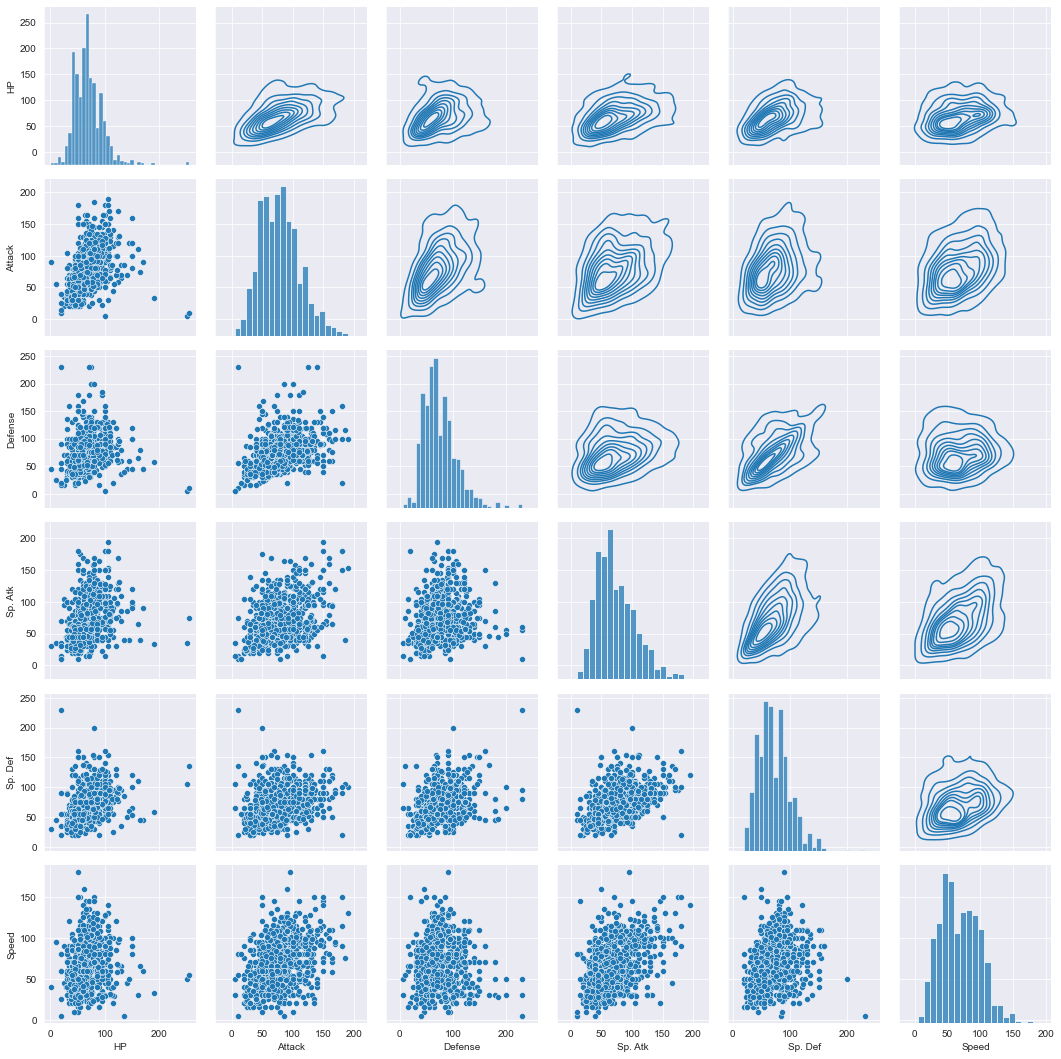

In [17]:
g = sns.PairGrid(data=pokemonDf[statsColumns], diag_sharey=False)
g.map_diag(sns.histplot)
g.map_lower(sns.scatterplot)
g.map_upper(sns.kdeplot)
plt.show()

<u>Observations :</u> 

* Extreme values for a stat are more present at the right side.
* It's seem that pokemons with high HP or Defense or Sp. Def tends towards having a low Speed.
* It's seem that pokemons with high Attack or Sp. Atk tends towards having a high Speed.

### Legendaries vs non-Legendaries

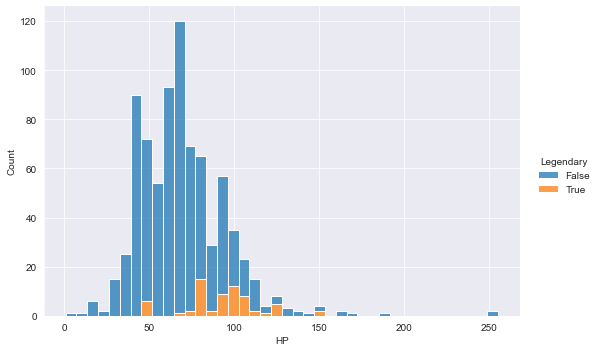

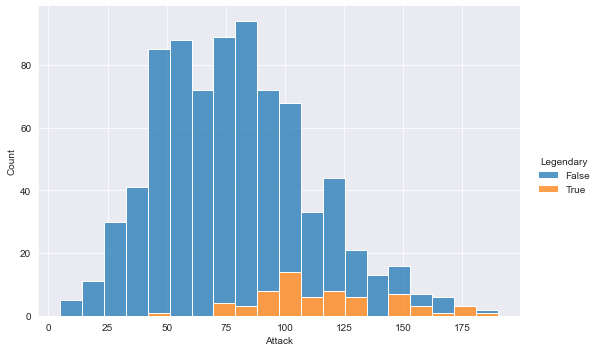

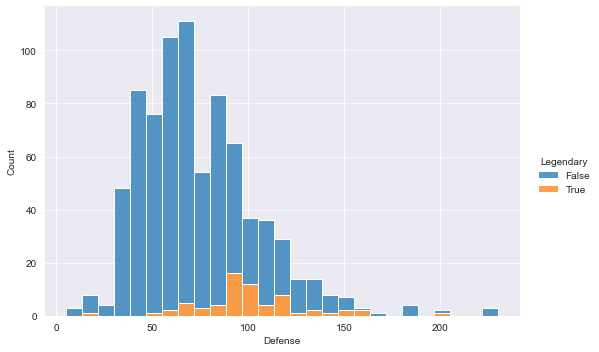

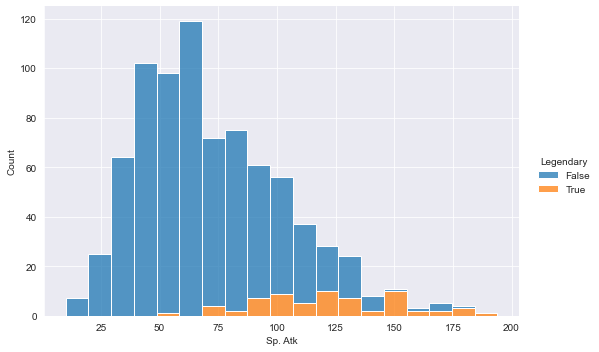

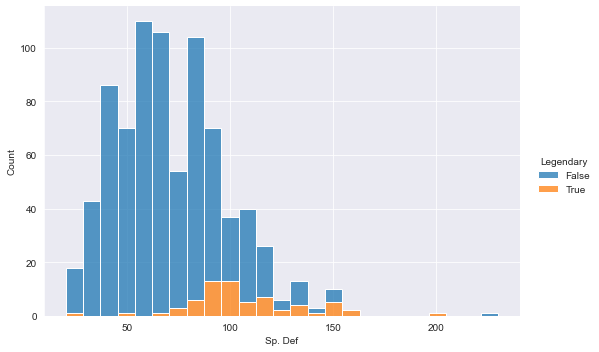

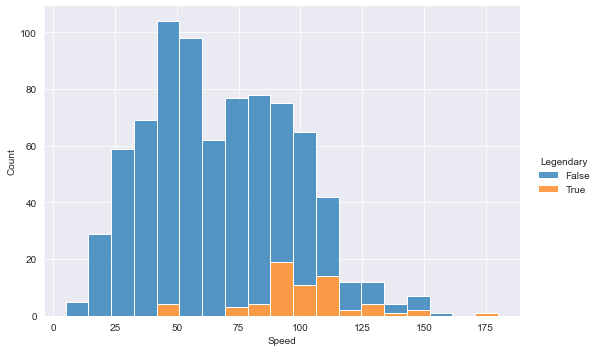

In [18]:
for col in statsColumns:
    sns.displot(data = pokemonDf, x =col, hue="Legendary", multiple="stack", aspect = 1.5)
    plt.show()

<u>Observation :</u>

Legendaries have a better stat distributions on every aspect.

## Which pokemon has the most wins ?

In [19]:
totalWinsSeries = combatsDf.Winner.value_counts()
totalLosesSeries = combatsDf.Loser.value_counts()
indexes = np.arange(1, 800 + 1, 1)

for index in indexes:
    if not(index in totalWinsSeries.index):
        totalWinsSeries.loc[index] = 0
    if not(index in totalLosesSeries.index):
        totalLosesSeries.loc[index] = 0

totalWinsSeries = totalWinsSeries.sort_index()
totalLosesSeries = totalLosesSeries.sort_index()

averageWinsSeries = totalWinsSeries / (totalWinsSeries + totalLosesSeries)

bestPokemonId = averageWinsSeries.dropna().sort_values(ascending=False).index[0]

print(pokemonDf.loc[bestPokemonId], '\n')
print(f"Battles = {totalWinsSeries[bestPokemonId] + totalLosesSeries[bestPokemonId]} | Wins : {totalWinsSeries[bestPokemonId]}")

Name          Mega Aerodactyl
Type 1                   Rock
Type 2                 Flying
HP                         80
Attack                    135
Defense                    85
Sp. Atk                    70
Sp. Def                    95
Speed                     150
Generation                  1
Legendary               False
TotalStats                615
Name: 155, dtype: object 

Battles = 129 | Wins : 127


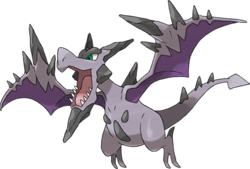

<u>Observation :</u>

Top winrate pokemon based on the data is Mega Aerodactyl. It has a high Speed and a high Attack stats.

## Which pokemon has the most loses ?

In [20]:
worstPokemonId = averageWinsSeries.dropna().sort_values(ascending=False).index[-1]
print(pokemonDf.loc[worstPokemonId], '\n')
print(f"Battles = {totalWinsSeries[worstPokemonId] + totalLosesSeries[worstPokemonId]} | Wins : {totalWinsSeries[worstPokemonId]}")

Name          Shuckle
Type 1            Bug
Type 2           Rock
HP                 20
Attack             10
Defense           230
Sp. Atk            10
Sp. Def           230
Speed               5
Generation          2
Legendary       False
TotalStats        505
Name: 231, dtype: object 

Battles = 135 | Wins : 0


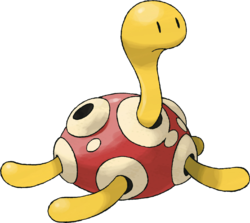

Observation :

Worst winrate pokemon based on data is Shuckle. It has amazing Defense and Sp. Def but the others stats are very low.

## Does the pokemon with the highest Speed stat always attack first in combat ?

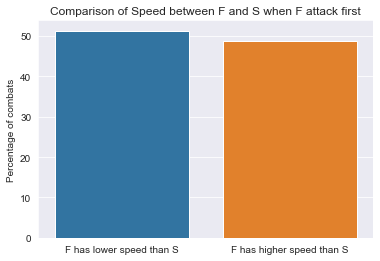

In [21]:
speedDiffArray = pokemonDf.loc[combatsDf.First_pokemon, "Speed"].values - pokemonDf.loc[combatsDf.Second_pokemon, "Speed"].values
speedComparison = (pd.Series(speedDiffArray) > 0).value_counts()

sns.barplot(x = ["F has lower speed than S", "F has higher speed than S"], y = speedComparison.sort_index().values/speedComparison.sum() *100)
plt.ylabel("Percentage of combats")
plt.title("Comparison of Speed between F and S when F attack first")
plt.show()

<u>Observation :</u> 
    
It's a close 50/50 almost like Speed did not influence which pokemon attack first. However this might result from the use of priority moves that makes the pokemon always attack first or last. We can't know for sure without seiing the moveset of the pokemons in battle.

<u>Note :</u>

It's not sure that attacking first means that the pokemon attacks first at every turn of the combat or only for the first turn.

## Does the winners types are effective against the losers ones ?

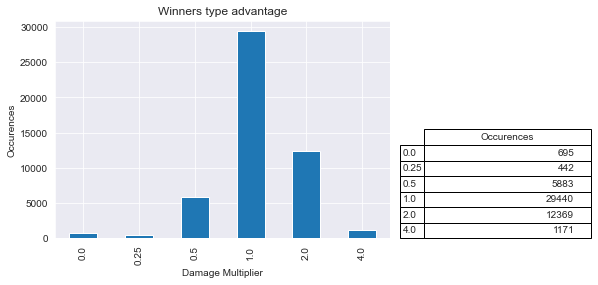

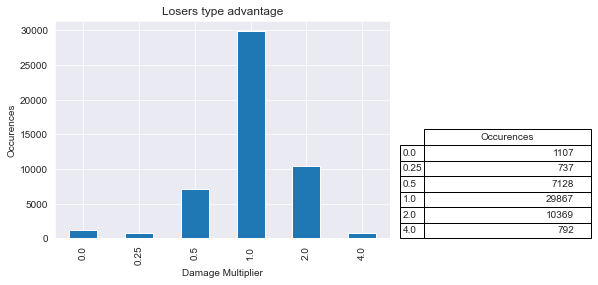

In [22]:
winnersDamageMultiplierSeries = combatsDf.apply(lambda x : getBestDamageMultiplier(x.Winner, x.Loser), axis= 1).value_counts().sort_index()
winnersDamageMultiplierSeries.plot.bar()
plt.table(cellText= winnersDamageMultiplierSeries.values.reshape(6,1), colLabels=["Occurences"], rowLabels=[idx for idx in winnersDamageMultiplierSeries.index], bbox = [1.1, 0, 0.5, 0.5])
plt.ylabel("Occurences")
plt.xlabel("Damage Multiplier")
plt.title("Winners type advantage")
plt.show()

losersDamageMultiplierSeries = combatsDf.apply(lambda x : getBestDamageMultiplier(x.Loser, x.Winner), axis= 1).value_counts().sort_index()
losersDamageMultiplierSeries.plot.bar()
plt.table(cellText= losersDamageMultiplierSeries.values.reshape(6,1), colLabels=["Occurences"], rowLabels=[idx for idx in losersDamageMultiplierSeries.index], bbox = [1.1, 0, 0.5, 0.5])
plt.ylabel("Occurences")
plt.xlabel("Damage Multiplier")
plt.title("Losers type advantage")
plt.show()

<u>Observation :</u>

* We can see there are more cases of winners having a type advantage than disadvantage but it's also the case for losers.
* The distribution looks in fact very similar between winners and losers for other damage multiplier values.
* We can see that when there is a 0 damage multiplier a pokemon can win the combat. So either the assumption that pokemons only use moves of their own types is wrong or it's the presence of this damage multiplier as previously defined itself that is wrong.

In theses regards, it's not an engineered feature we'll keep.

In [23]:
combatsDf.drop(inplace=True, columns=['First_pokemon_bestDamageMultiplier', 'Second_pokemon_bestDamageMultiplier'])

## Does the pokemon with the highest stats wins ?

### Total Stats

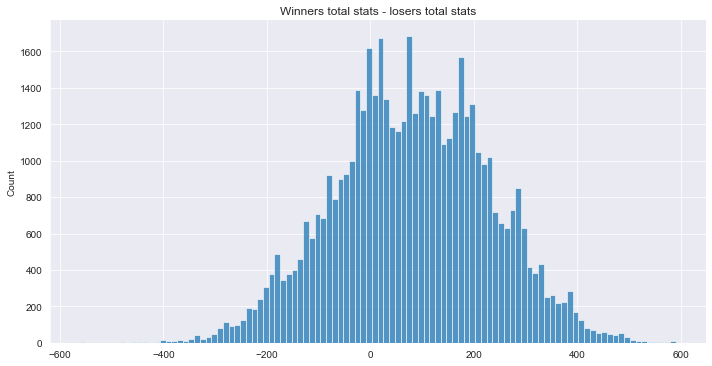

Avererage winners total stats - losers total stats :  79.77632


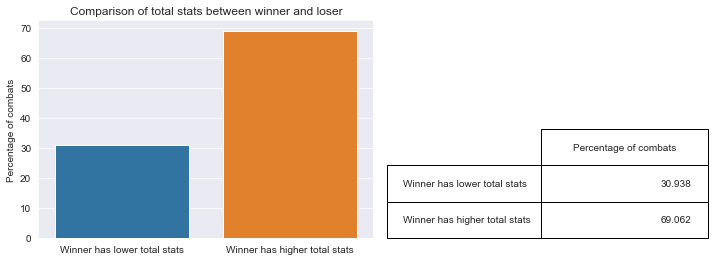

In [24]:
totalStatsDiffArray = pokemonDf.loc[combatsDf.Winner, "TotalStats"].values - pokemonDf.loc[combatsDf.Loser, "TotalStats"].values
totalStatsDiffSeries = pd.Series(totalStatsDiffArray)
totalStatsComparison = (totalStatsDiffSeries > 0).value_counts()

sns.displot(data=totalStatsDiffSeries, aspect=2)
plt.title("Winners total stats - losers total stats")
plt.show()

print("Avererage winners total stats - losers total stats : ",totalStatsDiffSeries.mean())

sns.barplot(x = ["Winner has lower total stats", "Winner has higher total stats"], y = totalStatsComparison.sort_index().values/ totalStatsComparison.sum() *100)
plt.table(cellText= (totalStatsComparison.sort_index().values/ totalStatsComparison.sum() *100).reshape(2,1), colLabels=["Percentage of combats"], rowLabels=["Winner has lower total stats", "Winner has higher total stats"],bbox = [1.5, 0, 0.5, 0.5])
plt.ylabel("Percentage of combats")
plt.title("Comparison of total stats between winner and loser")
plt.show()



<u>Observations :</u>

* In almost 70% of combats the winner has more total stats.
* On average, winners have $\approx$ 80 more in stats than losers.

We will now look this difference between stats a stat at a time.

### Stat by stat


 HP  :




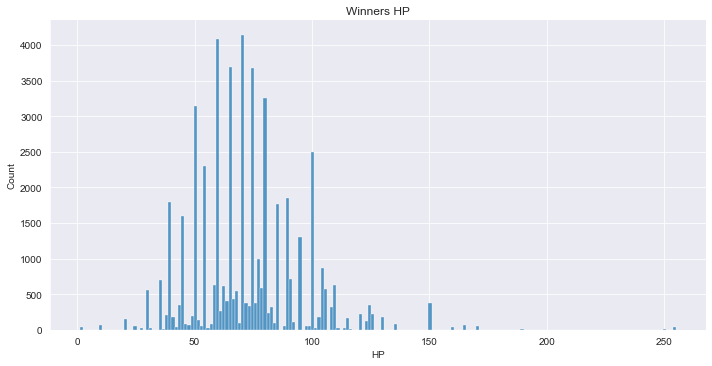

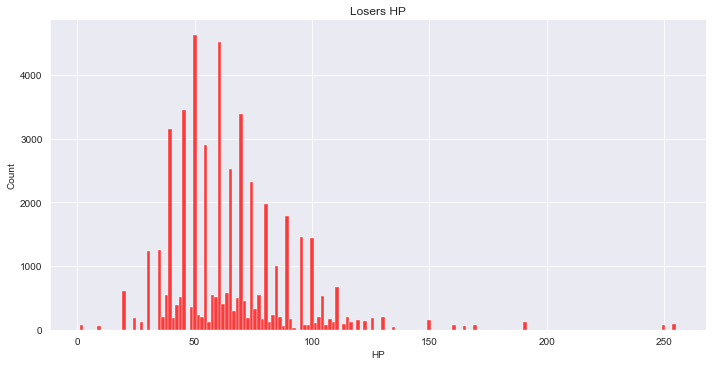

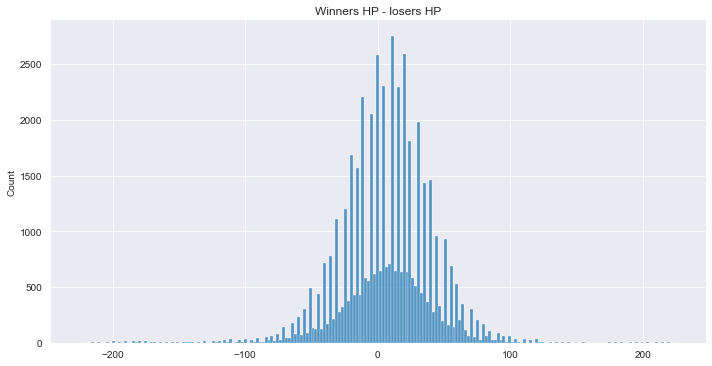

Avererage winners HP - losers HP :  6.8989


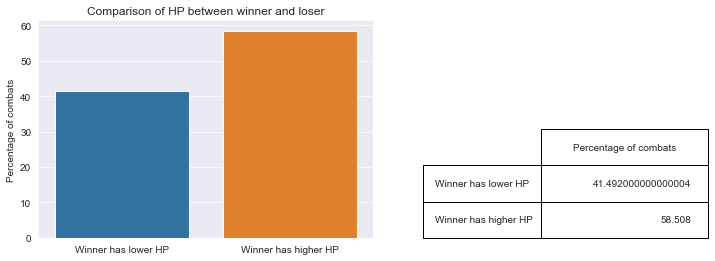


-----------------------------------------------------------------------------------------------------------------------------------------------


 Attack  :




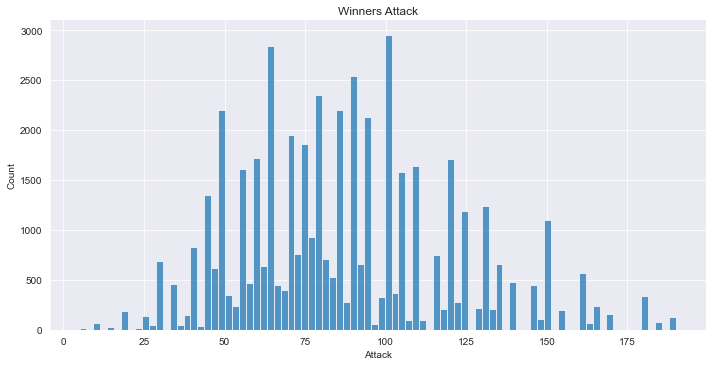

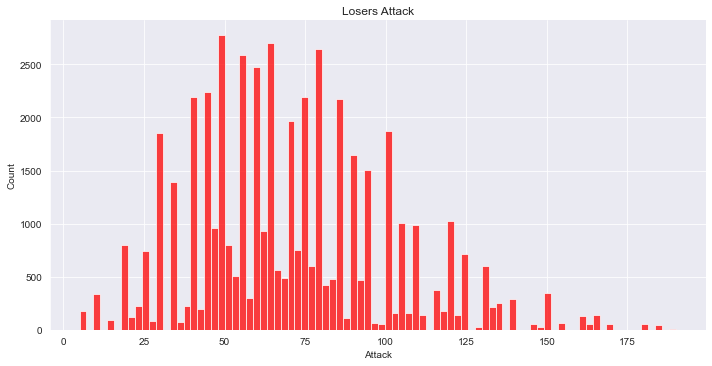

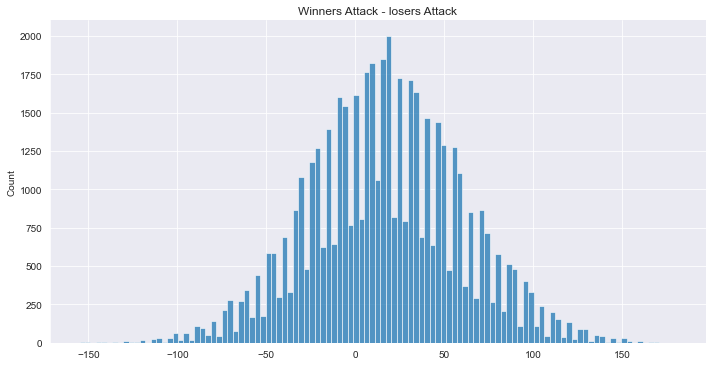

Avererage winners Attack - losers Attack :  16.67226


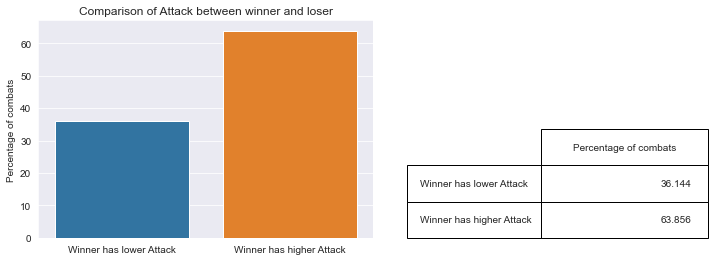


-----------------------------------------------------------------------------------------------------------------------------------------------


 Defense  :




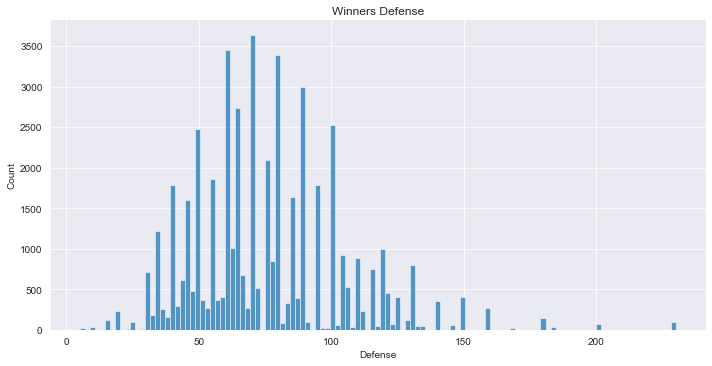

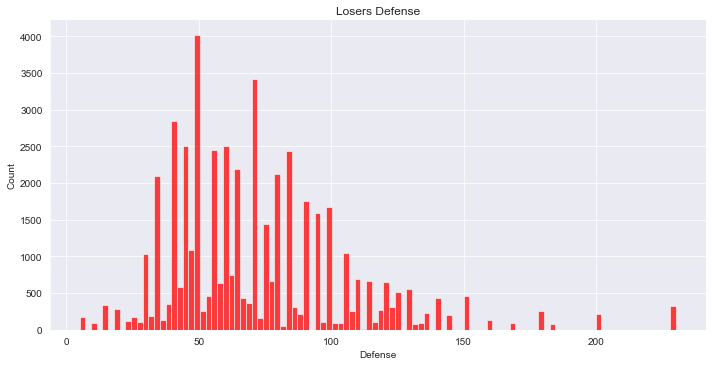

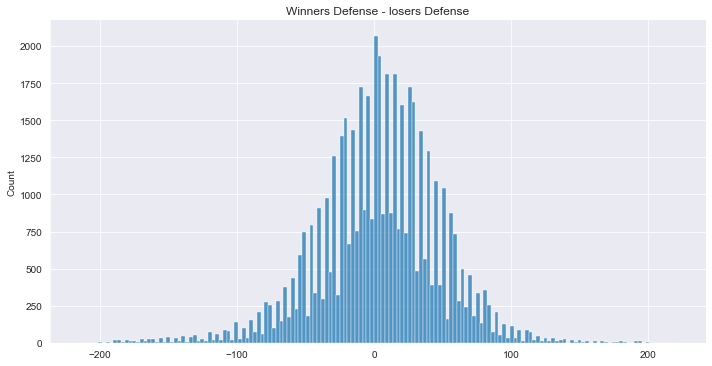

Avererage winners Defense - losers Defense :  3.5387


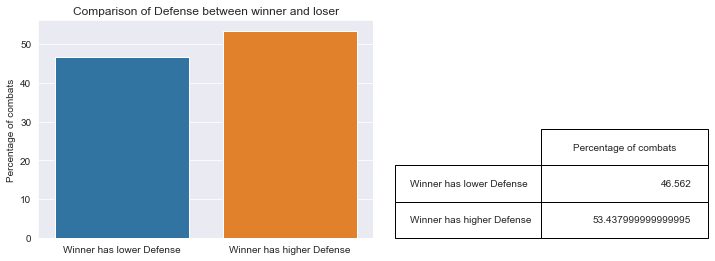


-----------------------------------------------------------------------------------------------------------------------------------------------


 Sp. Atk  :




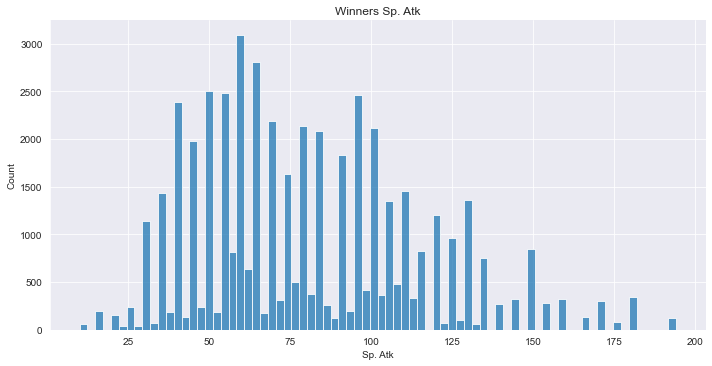

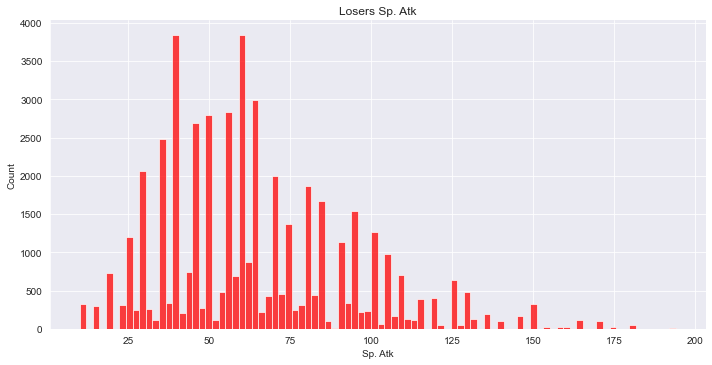

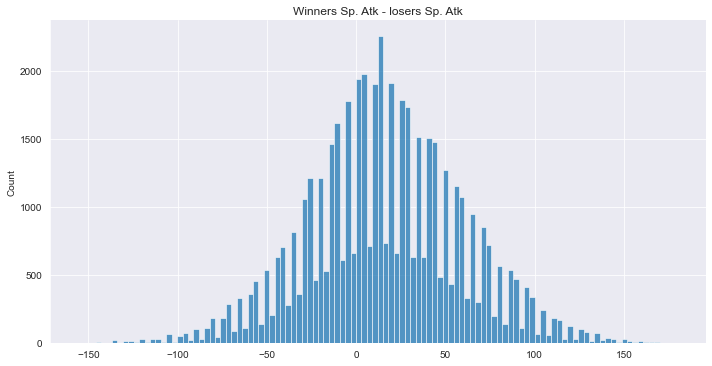

Avererage winners Sp. Atk - losers Sp. Atk :  16.07432


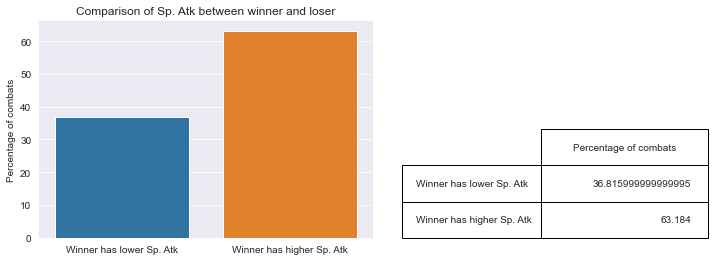


-----------------------------------------------------------------------------------------------------------------------------------------------


 Sp. Def  :




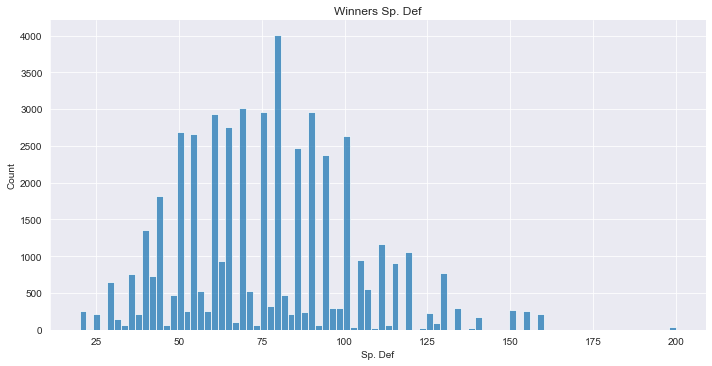

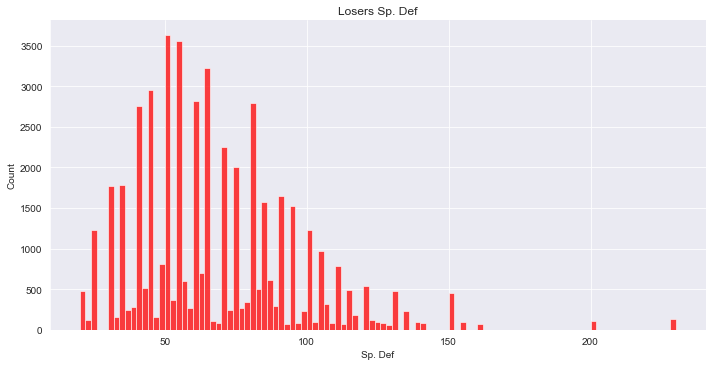

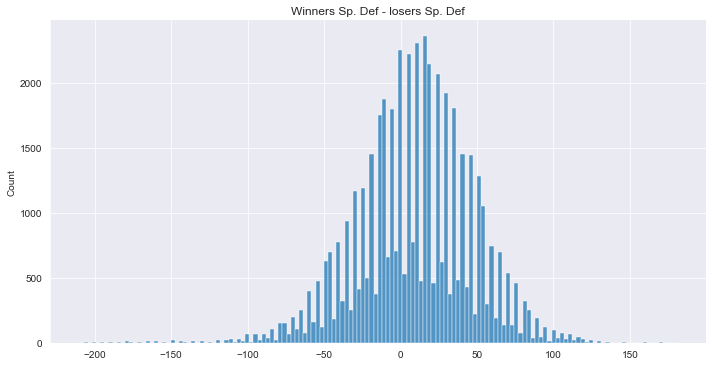

Avererage winners Sp. Def - losers Sp. Def :  8.61526


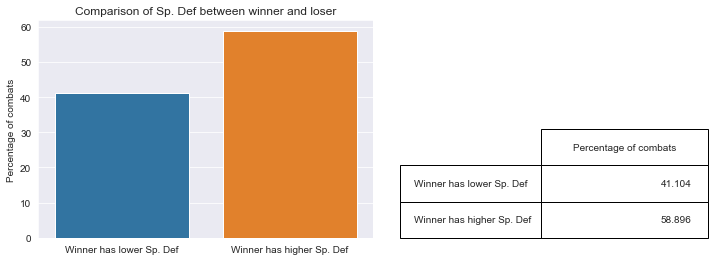


-----------------------------------------------------------------------------------------------------------------------------------------------


 Speed  :




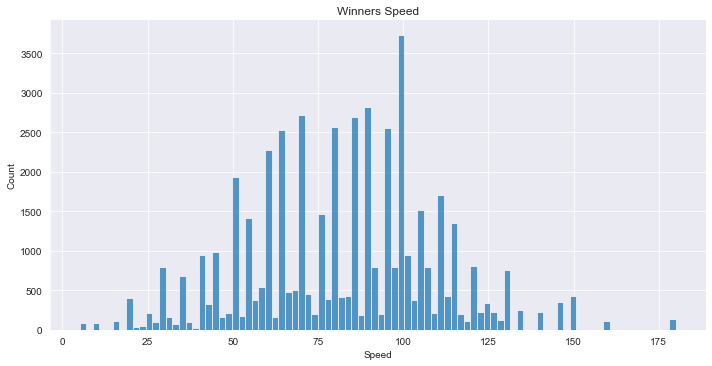

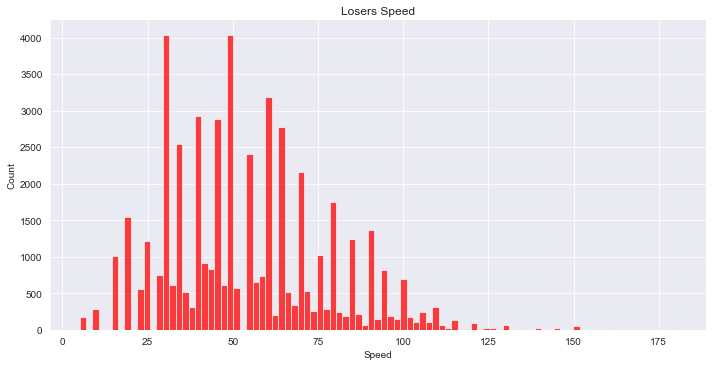

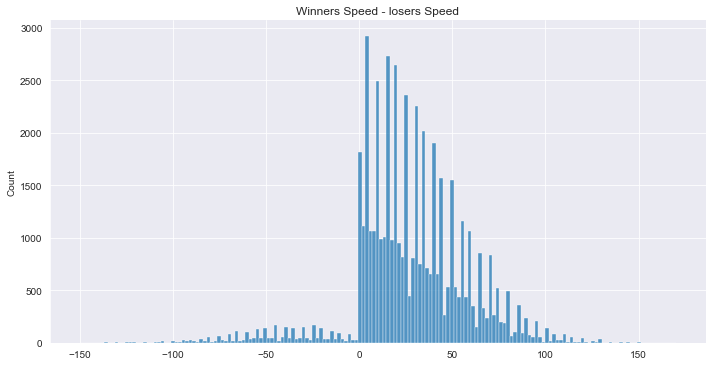

Avererage winners Speed - losers Speed :  27.97688


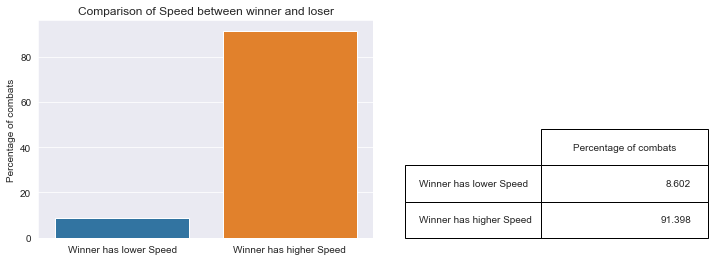


-----------------------------------------------------------------------------------------------------------------------------------------------



In [25]:
def statDiffBtwWinnerAndLoser(stat : str):
    print('\n',stat, " :\n\n")
    
    winnerStatsSeries = pokemonDf.loc[combatsDf.Winner, stat]
    losersStatsSeries = pokemonDf.loc[combatsDf.Loser, stat]

    sns.displot(data=winnerStatsSeries, aspect=2)
    plt.title("Winners " + stat)
    plt.show()
    
    sns.displot(data=losersStatsSeries, aspect=2, color='red')
    plt.title("Losers " + stat)
    plt.show()
    
    statDiffSeries = pd.Series(pokemonDf.loc[combatsDf.Winner, stat].values - pokemonDf.loc[combatsDf.Loser, stat].values)
    statComparison = (statDiffSeries > 0).value_counts()

    sns.displot(data=statDiffSeries, aspect=2)
    plt.title("Winners " + stat + " - losers " + stat)
    plt.show()
    
    print("Avererage winners " + stat + " - losers " + stat + " : ", statDiffSeries.mean())
    
    sns.barplot(x = ["Winner has lower " + stat, "Winner has higher " + stat], y = statComparison.sort_index().values/ statComparison.sum() *100)
    plt.ylabel("Percentage of combats")
    plt.title("Comparison of " + stat +" between winner and loser")
    plt.table(cellText= (statComparison.sort_index().values/ statComparison.sum() *100).reshape(2,1), colLabels=["Percentage of combats"], rowLabels=["Winner has lower " + stat, "Winner has higher " + stat],bbox = [1.5, 0, 0.5, 0.5])
    plt.show()
    print('\n-----------------------------------------------------------------------------------------------------------------------------------------------\n')

for stat in statsColumns:
    statDiffBtwWinnerAndLoser(stat)   

<u>Observations :</u>

* For every stat it is more likely that winners will have more of it than losers.
* Having more of Defense is close to a 50/50.
* Having more of Speed is a very important feature as more than 90% of winners have higher Speed. Our engineered feature hasMoreSpeed will prove very useful.

### Engineered stats features (ratios)

Since we're working with ratios a log-scale and the operator '/' rather than '-' will be used

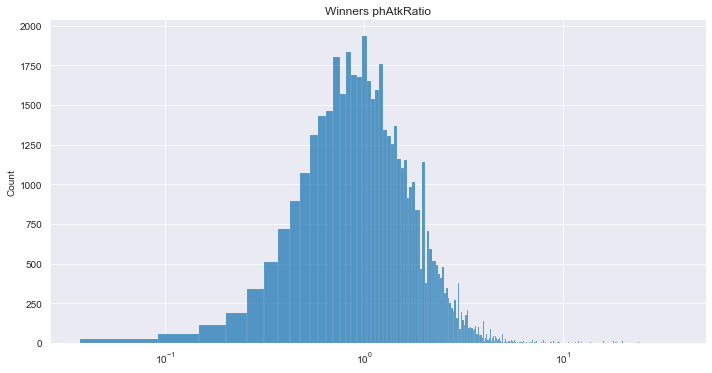

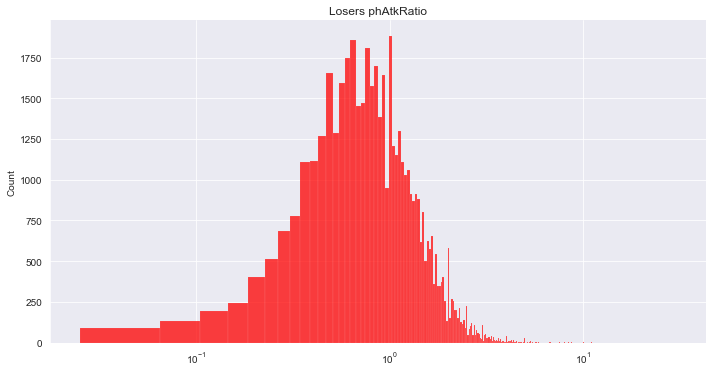

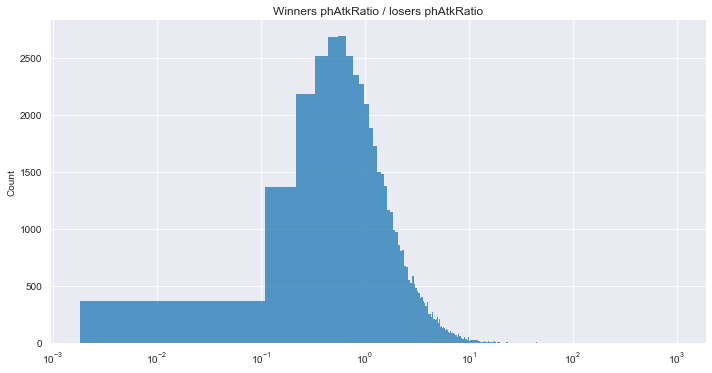

Avererage winners phAtkRatio / losers phAtkRatio :  3.3651413717405214


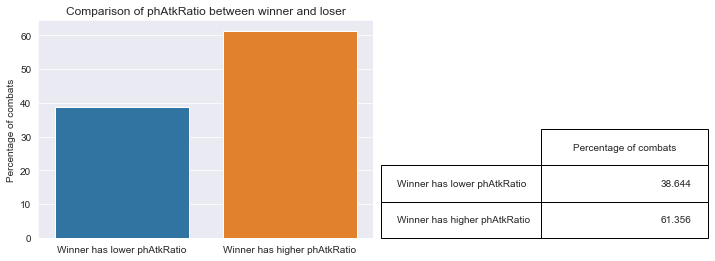

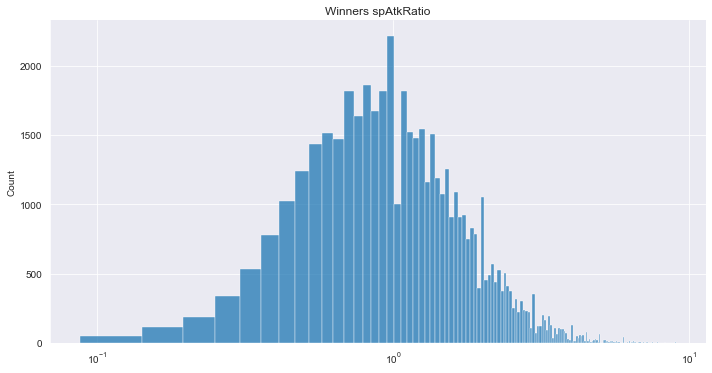

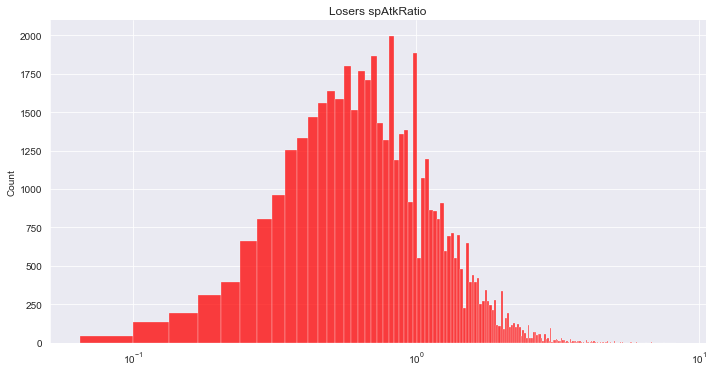

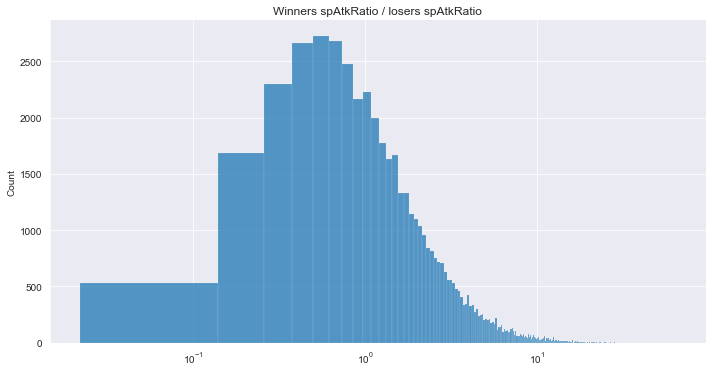

Avererage winners spAtkRatio / losers spAtkRatio :  2.4691189781762666


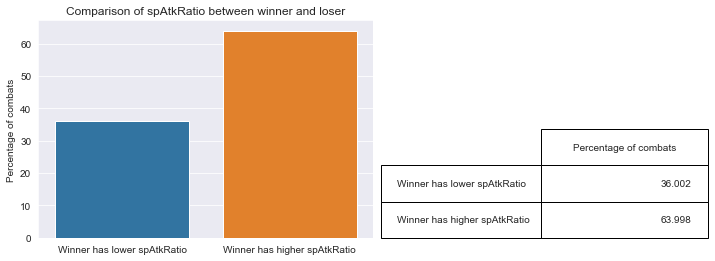

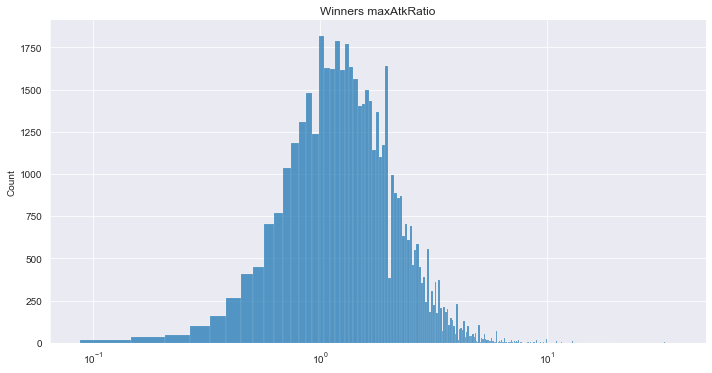

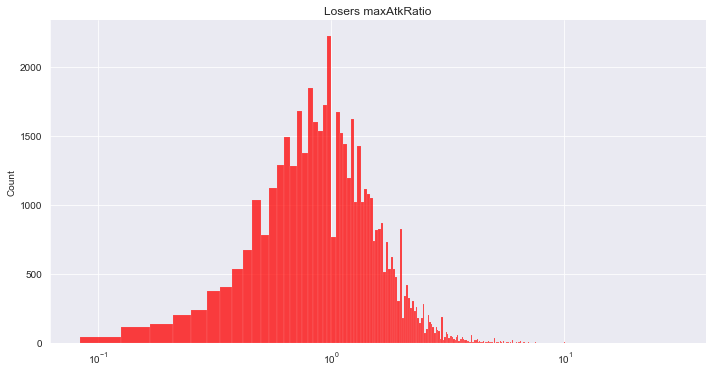

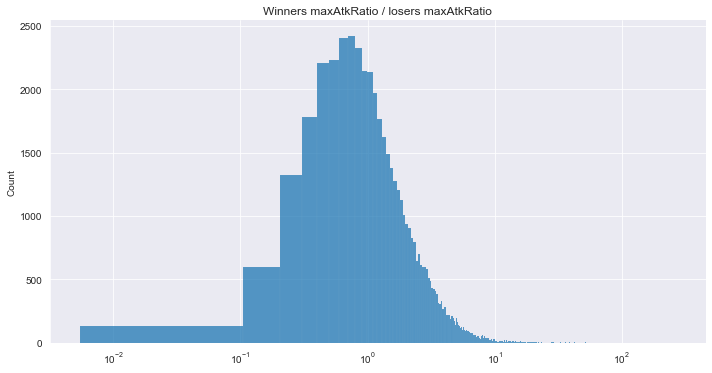

Avererage winners maxAtkRatio / losers maxAtkRatio :  2.3697362201757195


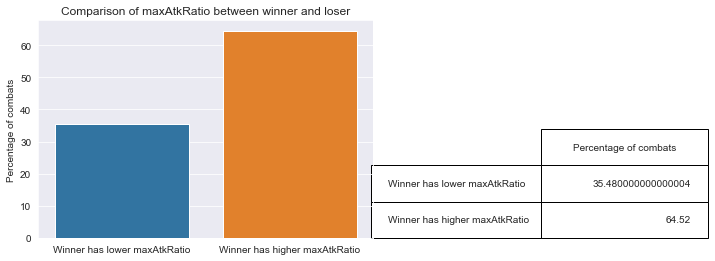

In [26]:
engineeredStatsFeatures = [
    'phAtkRatio',
    'spAtkRatio',
    'maxAtkRatio',
]

def engineeredStatDiffBtwWinnerAndLoser(stat : str):
    winnersEngineeredStatSeries = combatsDf.apply(lambda x: x["First_pokemon_" + stat] if (x.Winner == x.First_pokemon) else x["Second_pokemon_" + stat], axis=1) 
    losersEngineeredStatSeries = combatsDf.apply(lambda x:  x["Second_pokemon_" + stat] if (x.Winner == x.First_pokemon) else x["First_pokemon_" + stat], axis=1) 
    
    sns.displot(data=winnersEngineeredStatSeries, aspect=2)
    plt.title("Winners " + stat)
    plt.xscale('log')
    plt.show()
    
    sns.displot(data=losersEngineeredStatSeries, aspect=2, color='red')
    plt.title("Losers " + stat)
    plt.xscale('log')
    plt.show()
    
    engineeredStatDiffSeries = combatsDf.apply(lambda x: x["First_pokemon_" + stat] / x["Second_pokemon_" + stat] if (x.Winner == x.First_pokemon) else x["Second_pokemon_" + stat] / x["First_pokemon_" + stat], axis=1) 
    
    engineeredStatComparison = (combatsDf.apply(lambda x: x["First_pokemon_" + stat] - x["Second_pokemon_" + stat] if (x.Winner == x.First_pokemon) else x["Second_pokemon_" + stat] - x["First_pokemon_" + stat], axis=1)  > 0).value_counts()

    sns.displot(data=engineeredStatDiffSeries, aspect=2)
    plt.title("Winners " + stat + " / losers " + stat)
    plt.xscale('log')
    plt.show()
    
    print("Avererage winners " + stat + " / losers " + stat + " : ", engineeredStatDiffSeries.mean())
    
    sns.barplot(x = ["Winner has lower " + stat, "Winner has higher " + stat], y = engineeredStatComparison.sort_index().values/ engineeredStatComparison.sum() *100)
    plt.ylabel("Percentage of combats")
    plt.title("Comparison of " + stat +" between winner and loser")
    plt.table(cellText= (engineeredStatComparison.sort_index().values/ engineeredStatComparison.sum() *100).reshape(2,1), colLabels=["Percentage of combats"], rowLabels=["Winner has lower " + stat, "Winner has higher " + stat],bbox = [1.5, 0, 0.5, 0.5])
    plt.show()

for stat in engineeredStatsFeatures:
    engineeredStatDiffBtwWinnerAndLoser(stat)   

<u>Observations</u>:

* Our engineered stats features seems to be working good.
* We'll only keep the maxAtkRatio as it is a function of the others two that performs better.

In [27]:
combatsDf.drop(inplace=True, columns=['First_pokemon_phAtkRatio','First_pokemon_spAtkRatio','Second_pokemon_phAtkRatio','Second_pokemon_spAtkRatio'])

# Predict outcome of future combats

In [28]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, DetCurveDisplay, RocCurveDisplay
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import make_column_transformer
from sklearn import set_config
set_config(display='diagram') 

Given a combat between two pokemons noted as ($pokemon_1$,$pokemon_2$), we have to predict the winner. We can reformulate this as a binary classification problem where the classes are :

$$
\begin{align*}
    \omega_1 = 1 : pokemon_1 \text{ wins the combat} \\
    \omega_2 = 0 : pokemon_2 \text{ wins the combat} 
\end{align*}
$$

The explanatory variables will be the characteristics of each pokemon in the combat (type, stats, generation, legendary).

## Creating train and test sets

In [29]:
X = pd.DataFrame()

featuresColsPokemonDf = [
    'HP',
    'Type 1',
    'Type 2',     
    'Generation',
    'Legendary',
]

featuresCombatsDf = combatsDf.loc[:,['First_pokemon_maxAtkRatio','Second_pokemon_maxAtkRatio','First_pokemon_hasMoreSpeed']]

for col in featuresColsPokemonDf:
    for pokemon in ["First_pokemon", "Second_pokemon"]:  
        X[pokemon + "_" + col] = pokemonDf[col].loc[combatsDf[pokemon]].values

X= pd.concat([X, featuresCombatsDf], axis = 1)
          
# Replacing Winner with omega_1 = 1 or omega_2 = 0
y = pd.Series([1 if (combatsDf.First_pokemon[index] == combatsDf.Winner[index]) else 0 for index in combatsDf.index])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## Preprocessing

The categorical variables will be encode with One Hot Encoding and the numerical variables will be scaled with MinMaxScaler.

In [30]:
features = X.columns.to_list()

# Get columns that have Type or Generation in their name (i.e.a our categorical variables)
pattern = ".*Type.*|.*Generation.*"
r = re.compile(pattern)
categorical_features  = list(filter(r.match, features))

# Get the ohter columns (i.e. our numeric variables)
r = re.compile("(?!" + pattern + ")")
numeric_features  = list(filter(r.match, features))

preprocessor = make_column_transformer(
    (OneHotEncoder(sparse= False, handle_unknown='ignore'), categorical_features),
    (MinMaxScaler(), numeric_features)
)

## Logistic Regression

In [31]:
logReg = Pipeline(
    steps=[('preprocessor', preprocessor), ('logistic', LogisticRegression(random_state=42, max_iter=1000))]
)

logReg.fit(X_train, y_train)
y_pred = logReg.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.94      0.95      8663
           1       0.94      0.94      0.94      7837

    accuracy                           0.94     16500
   macro avg       0.94      0.94      0.94     16500
weighted avg       0.94      0.94      0.94     16500



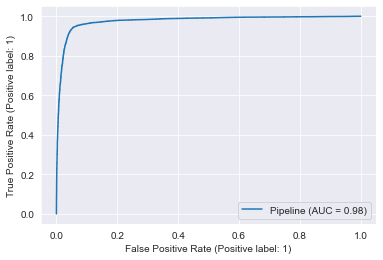

In [32]:
RocCurveDisplay.from_estimator(logReg, X_test, y_test)
plt.show()

## Feature selection

We'll check the coefficients to have a glimpse of each variable importance.

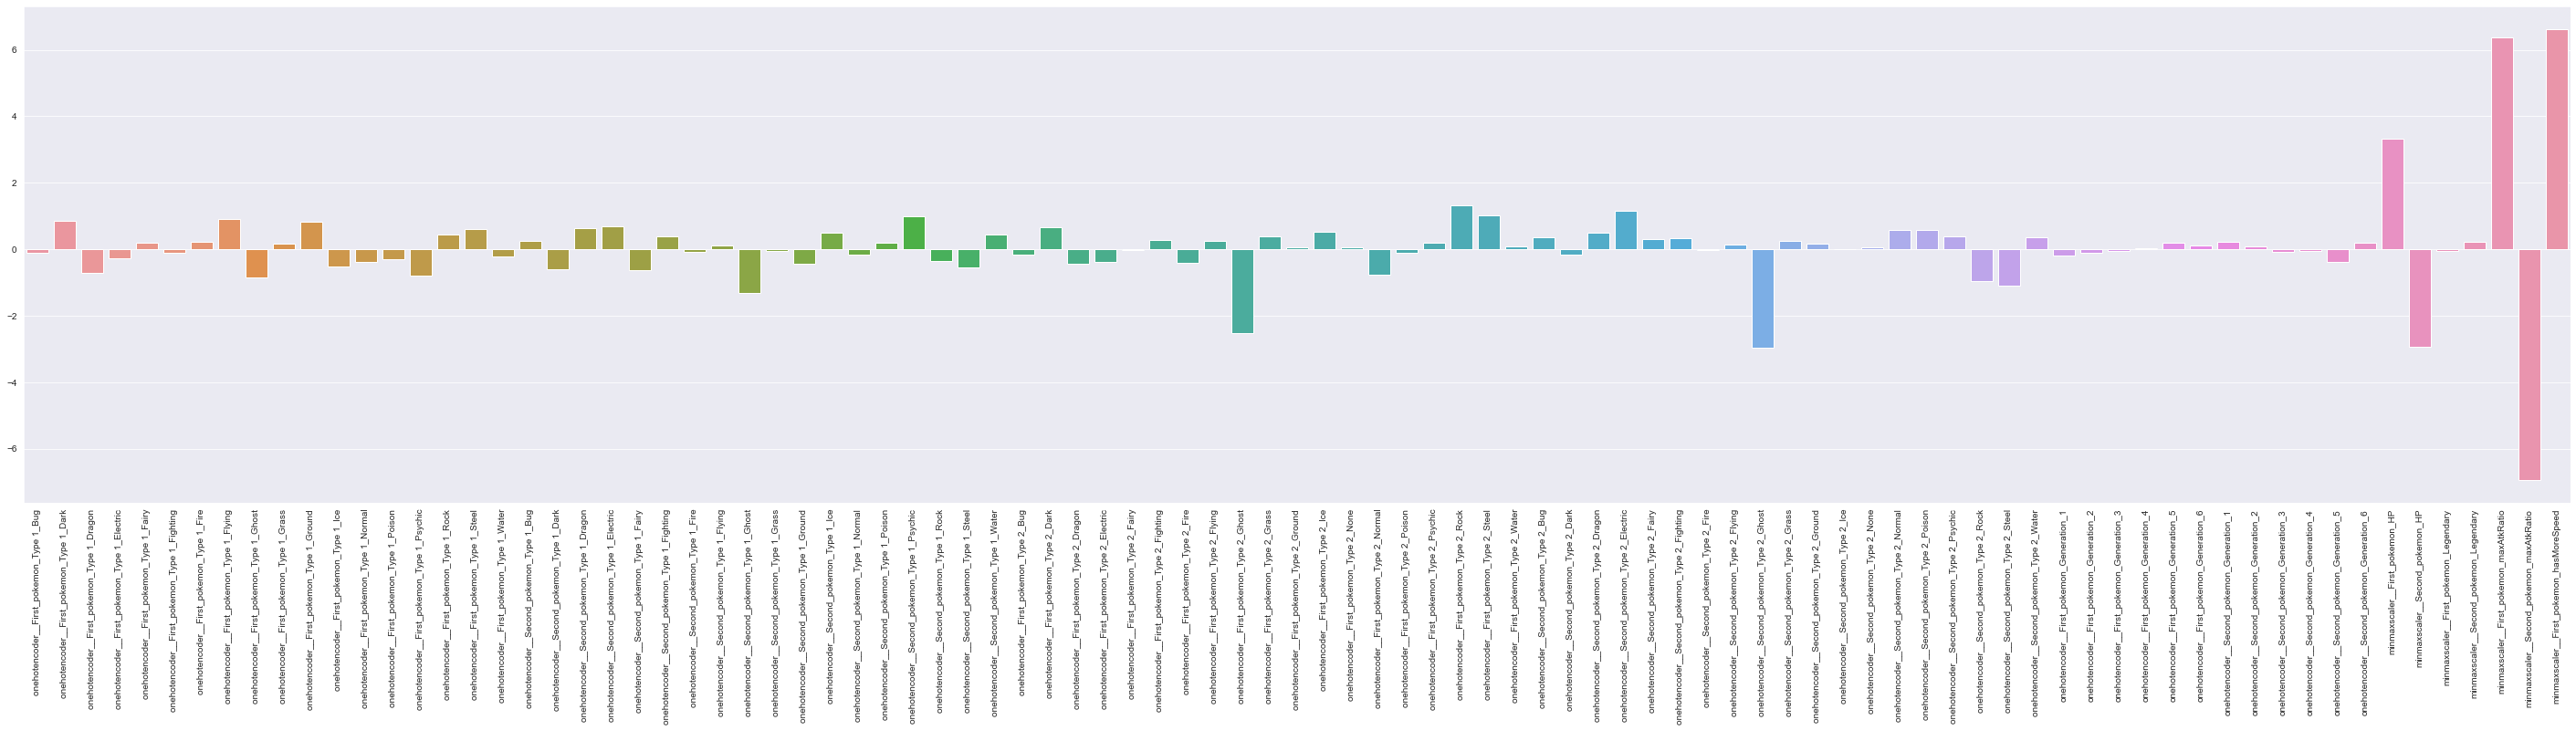

In [33]:
importance = logReg['logistic'].coef_[0]
plt.figure(figsize=(50,10))
sns.barplot(x=logReg['preprocessor'].get_feature_names_out(), y=importance)
plt.xticks(rotation=90)
plt.show()

<u>Observations :</u>

* Our engineered features have a great importance (big coefficients in absolute value)
* HP also have importance
* Some types have a greater importances than other

However Generation and Legendary seem to not hold great importance (all coefficents close to 0). We'll try the same model without these features.

In [34]:
X  = X[X.columns.drop(list(X.filter(regex=".*Legendary.*|.*Generation.*")))]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

features = X.columns.to_list()

# Get columns that have Type or Generation in their name (i.e.a our categorical variables)
pattern = ".*Type.*|.*Generation.*"
r = re.compile(pattern)
categorical_features  = list(filter(r.match, features))

# Get the ohter columns (i.e. our numeric variables)
r = re.compile("(?!" + pattern + ")")
numeric_features  = list(filter(r.match, features))

preprocessor = make_column_transformer(
    (OneHotEncoder(sparse= False, handle_unknown='ignore'), categorical_features),
    (MinMaxScaler(), numeric_features)
)

logReg = Pipeline(
    steps=[('preprocessor', preprocessor), ('logistic', LogisticRegression(random_state=42, max_iter=1000))]
)

logReg.fit(X_train, y_train)
y_pred = logReg.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.94      0.95      8663
           1       0.94      0.94      0.94      7837

    accuracy                           0.94     16500
   macro avg       0.94      0.94      0.94     16500
weighted avg       0.94      0.94      0.94     16500



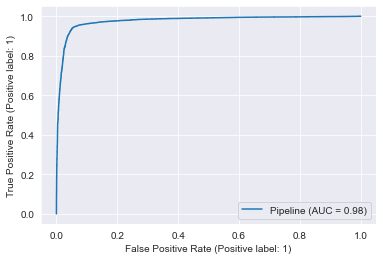

In [35]:
RocCurveDisplay.from_estimator(logReg, X_test, y_test)
plt.show()

The drop of the two features did not affect the scoring metrics. They were indeed not so important in predicting the outcome of combats.

## Tuning hyperparameters

Finally we do some small hyperparameters tuning.

Best parameters :  {'logistic__C': 100, 'logistic__max_iter': 100}


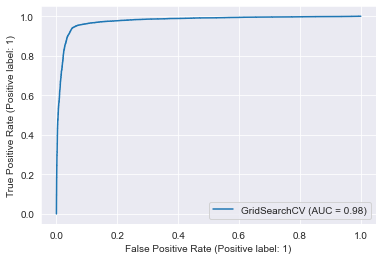

In [36]:
param_grid = [    
    {
    'logistic__C' : [100, 10, 1.0, 0.1, 0.01],
    'logistic__max_iter' : [100, 1000, 2500, 5000]
    }
]

grid_search = GridSearchCV(logReg, param_grid=param_grid,scoring = 'roc_auc')
best_logReg = grid_search.fit(X_train, y_train)

print("Best parameters : ", best_logReg.best_params_)

RocCurveDisplay.from_estimator(best_logReg, X_test, y_test)
plt.show()

In [37]:
y_pred = best_logReg.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95      8663
           1       0.94      0.94      0.94      7837

    accuracy                           0.94     16500
   macro avg       0.94      0.94      0.94     16500
weighted avg       0.94      0.94      0.94     16500



# What to do next ?

* Check the performance of other classifiers
* Assert logistic regression assumptions
* Check the importance of features rather with Wald test or likelihood ratio test